In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import neurokit2 as nk
from datetime import datetime, timedelta
import pytz
import pickle
import os
from utility import read_timestamp, generate_info
import utility
import warnings
warnings.filterwarnings("ignore")
from matplotlib.patches import PathPatch

In [2]:
meta_eoi = ['EYECLOSE', 'IN', 'QF',  'QS', 'RJ',]

colors = {'EYEOPEN':  '#00A0B0', 'BASELINE':  '#00A0B0', 'EYECLOSE':  '#00A0B0',
 'IN': '#6A4A3C',
 'QF': '#cc333f',
 'QS': '#eb6841',
 'RJ': '#edc951',
 'READ': '#a58c38',
 'LISTEN': '#f2d985',
 'SPEAK': '#a4482d', 'TYPE': '#ef8666'}


boxprops={
    'palette': colors,
     'flierprops': {"marker": "x"},
    'boxprops': {"edgecolor": "white"},
     'medianprops':{"color": "white", "linewidth": 1.5},
    'showmeans': True, 'meanline': True, 'meanprops': {'color': 'red','ls': '--', 'lw': 1.5},
}


SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 20


plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Analysis

In [4]:
df = pd.read_csv('../results/aggregated_bvp.csv', index_col=0)
df = df[df.pid != 'PA17']
df

,pid,topic,cond,meta_cond,IBI_Mean,NPeaks,HRV_MeanNN,HRV_SDNN,HRV_RMSSD
0,PA9,743.0,LISTEN,RJ,8.730879,0,NaN,NaN,NaN
1,PA9,419.0,LISTEN,RJ,14.661707,0,NaN,NaN,NaN
2,PA9,708.0,LISTEN,RJ,31.247460,4,677.083333,140.914055,217.631067
3,PA9,725.0,LISTEN,RJ,20.184304,2,8828.125000,NaN,NaN
4,PA9,711.0,LISTEN,RJ,17.987083,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
744,PA21,Baseline,EYECLOSE,EYECLOSE,2.250236,0,NaN,NaN,NaN
745,PA21,355.0,TYPE,QS,77.166318,12,775.568182,440.019127,671.020532
746,PA21,725.0,QF,QF,4.870526,0,NaN,NaN,NaN
747,PA21,320.0,QF,QF,32.194737,4,1880.208333,980.315704,1429.025632


In [5]:
df.meta_cond.value_counts()

meta_cond
RJ          176
IN          176
QS          176
QF          176
EYECLOSE     24
Name: count, dtype: int64

In [15]:
merge_df = df[['pid', 'meta_cond', 'IBI_Mean']]\
    .groupby(['pid', 'meta_cond']).mean().reset_index(drop=False)
merge_df

,pid,meta_cond,IBI_Mean,NPeaks
0,PA10,EYECLOSE,26.637200,3.000000
1,PA10,IN,34.370378,5.666667
2,PA10,QF,24.413454,3.333333
3,PA10,QS,40.907594,5.333333
4,PA10,RJ,36.298730,5.666667
...,...,...,...,...
115,PA9,EYECLOSE,13.161777,0.000000
116,PA9,IN,9.291618,1.000000
117,PA9,QF,10.954907,1.500000
118,PA9,QS,43.664422,6.800000


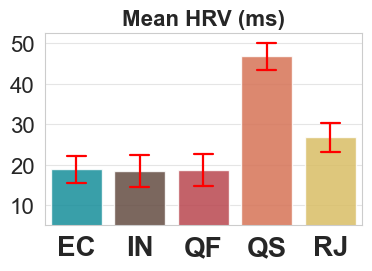

In [18]:
_, axes = plt.subplots(figsize=(4, 3))
sns.barplot(data=merge_df, x='meta_cond', y='IBI_Mean', ax=axes, order=meta_eoi,
            palette=colors, errwidth=1.6,\
            errorbar='se', errcolor='red',capsize=0.3, alpha=0.85)
axes.grid(axis='y', alpha=0.5)
axes.set_xlabel(None)
axes.set_ylabel(None)
labels = [item.get_text() for item in axes.get_xticklabels()]
labels[0] = 'EC'
axes.set_xticklabels(labels)
axes.set_yticks(np.arange(0, 55, 10))
axes.set_ylim(5)

plt.xticks(fontweight='bold')
plt.title('Mean HRV (ms)',weight='bold')
plt.tight_layout()
plt.savefig('../results/HRV_all.pdf', dpi=500)
plt.show()

In [13]:
import pingouin as pg

df = df[~df.meta_cond.isin(['EYEOPEN'])]
df.meta_cond.value_counts()

meta_cond
RJ          181
IN          181
QS          181
QF          181
EYECLOSE     25
Name: count, dtype: int64

In [14]:
tb = pg.pairwise_tests(dv='IBI_Mean', within='meta_cond', subject='pid', data=df, effsize='CLES',  correction=False, parametric=False)#, return_desc=True)
tb.loc[:, 'p-corr'] = tb['p-unc'].values * 4
tb.loc[:, 'variable'] = 'IBI_Mean'
tb = tb.round(3)
tb.to_csv('../results/bvp_posthoc.csv')
tb

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,CLES,p-corr,variable
0,meta_cond,EYECLOSE,IN,True,False,156.0,two-sided,0.874,0.542,3.496,IBI_Mean
1,meta_cond,EYECLOSE,QF,True,False,147.0,two-sided,0.692,0.547,2.766,IBI_Mean
2,meta_cond,EYECLOSE,QS,True,False,0.0,two-sided,0.000,0.069,0.000,IBI_Mean
3,meta_cond,EYECLOSE,RJ,True,False,34.0,two-sided,0.000,0.262,0.001,IBI_Mean
4,meta_cond,IN,QF,True,False,157.0,two-sided,0.895,0.504,3.579,IBI_Mean
5,meta_cond,IN,QS,True,False,3.0,two-sided,0.000,0.083,0.000,IBI_Mean
6,meta_cond,IN,RJ,True,False,34.0,two-sided,0.000,0.291,0.001,IBI_Mean
7,meta_cond,QF,QS,True,False,1.0,two-sided,0.000,0.070,0.000,IBI_Mean
8,meta_cond,QF,RJ,True,False,41.0,two-sided,0.001,0.262,0.002,IBI_Mean
9,meta_cond,QS,RJ,True,False,3.0,two-sided,0.000,0.869,0.000,IBI_Mean


## Process

In [90]:
plist, candlist = utility.get_candlist(exclude=['PA14'])
pinfos = generate_info(plist, exclude=None, parent_dir="../data")

N. Selected Participants: 25 N. Selected Trials: 181
[5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 27, 28, 29, 30, 31, 32, 33]
[('PA6', 314), ('PA7', 314), ('PA8', 314), ('PA9', 314), ('PA11', 314), ('PA12', 314), ('PA13', 314), ('PA15', 314), ('PA17', 314), ('PA18', 314), ('PA19', 314), ('PA20', 314), ('PA24', 314), ('PA27', 314), ('PA28', 314), ('PA33', 314), ('PA7', 320), ('PA8', 320), ('PA9', 320), ('PA10', 320), ('PA5', 320), ('PA11', 320), ('PA12', 320), ('PA18', 320), ('PA20', 320), ('PA21', 320), ('PA22', 320), ('PA28', 320), ('PA30', 320), ('PA31', 320), ('PA32', 320), ('PA33', 320), ('PA6', 353), ('PA8', 353), ('PA9', 353), ('PA12', 353), ('PA16', 353), ('PA17', 353), ('PA18', 353), ('PA22', 353), ('PA27', 353), ('PA28', 353), ('PA29', 353), ('PA30', 353), ('PA31', 353), ('PA33', 353), ('PA7', 355), ('PA8', 355), ('PA9', 355), ('PA5', 355), ('PA11', 355), ('PA12', 355), ('PA15', 355), ('PA18', 355), ('PA19', 355), ('PA20', 355), ('PA21', 355), ('PA22', 3

In [93]:
data = {}

for p, files in pinfos.items():
    epochs, events = read_timestamp(files['timestamp_file'], files['tskey_file'])[2:]
    input_file = os.path.join(files['folder_dir'], 'BVP_clean.csv')
    df = pd.read_csv(input_file, index_col=0)
    df.loc[:, 'pid'] = p
    df = utility.attach_info(p, df, epochs, events, candlist, plist, max_duration=None)
    
    data.update({p: {'epochs': epochs, 'time': events, 'data': df}})
    
print('Total Valid Data:', len(data))

Total Valid Data: 25


In [92]:
agg_df = []
max_duration = 10 
for p, temp in data.items():
    df = temp['data']
    valid_topics = utility.cond_balance_topic(df)
    
    for (topic, cond) in df[['topic', 'cond']].value_counts().index:
        if topic not in valid_topics: continue
        
        if cond == '+1': continue  
        selection = df[(df.topic == topic) & (df.cond == cond)]
        selection.loc[:, 'sec'] -= selection.sec.values[0]
        
        if max_duration:
            selection = selection[selection.sec < max_duration]
        
        selection.reset_index(inplace=True, drop=True)
        
        val = [p, topic, cond, selection.meta_cond.values[0], np.mean(selection.PPG_Rate.values)]
        agg_df.append(val)

agg_df = pd.DataFrame(agg_df, columns=['pid', 'topic', 'cond', 'meta_cond', 'IBI_Mean'])
agg_df

,pid,topic,cond,meta_cond,IBI_Mean,NPeaks,HRV_MeanNN,HRV_SDNN,HRV_RMSSD
0,PA9,743.0,LISTEN,RJ,8.730879,0,NaN,NaN,NaN
1,PA9,419.0,LISTEN,RJ,14.661707,0,NaN,NaN,NaN
2,PA9,708.0,LISTEN,RJ,31.247460,4,677.083333,140.914055,217.631067
3,PA9,725.0,LISTEN,RJ,20.184304,2,8828.125000,NaN,NaN
4,PA9,711.0,LISTEN,RJ,17.987083,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
744,PA21,Baseline,EYECLOSE,EYECLOSE,2.250236,0,NaN,NaN,NaN
745,PA21,355.0,TYPE,QS,77.166318,12,775.568182,440.019127,671.020532
746,PA21,725.0,QF,QF,4.870526,0,NaN,NaN,NaN
747,PA21,320.0,QF,QF,32.194737,4,1880.208333,980.315704,1429.025632


In [47]:
agg_df.to_csv('../results/aggregated_bvp.csv')